In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
from scipy.stats import norm
import seaborn as sns
import geopandas as gpd

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

## 1- Loading Data

In [7]:
#Reading the dataframe

input_directory = './input/'

covid_df = pd.read_csv(input_directory + 'combined_df.csv', index_col=0, dtype={'GEOID':str})

In [8]:
covid_df.shape

(108605, 147)

In [9]:
covid_df.isnull().sum().sum()

0

In [10]:
covid_df.sort_values(inplace=True, by=["date_start_period", "GEOID"])

In [11]:
covid_df

,GEOID,NAME,State_Name,STATEFP,COUNTYFP,date_end_period,date_start_period,date_end_lag,date_start_lag,LOG_DELTA_INC_RATE_T,...,pct_part_time_work_behavior_devices_baselined_T_4,pct_delivery_behavior_devices_baselined_T_4,distance_traveled_from_home_baselined_T_4,median_home_dwell_time_baselined_T_4,pct_completely_home_device_count_slope_T_4,pct_full_time_work_behavior_devices_slope_T_4,pct_part_time_work_behavior_devices_slope_T_4,pct_delivery_behavior_devices_slope_T_4,distance_traveled_from_home_slope_T_4,median_home_dwell_time_slope_T_4
0,01001,Autauga,Alabama,1,1,2020-04-04,2020-03-29,2020-03-28,2020-03-01,0.684831,...,-1.376835,0.080430,1.562443,-9.222329,-0.635825,0.676892,0.112197,-0.161042,-0.521814,0.835106
1,01003,Baldwin,Alabama,1,3,2020-04-04,2020-03-29,2020-03-28,2020-03-01,0.608396,...,-1.707145,0.017373,20.395673,-11.526151,-0.564465,0.835259,0.658430,0.324330,0.938332,0.376323
2,01005,Barbour,Alabama,1,5,2020-04-04,2020-03-29,2020-03-28,2020-03-01,0.244551,...,-0.388489,0.192245,-1.102112,-14.349953,-0.222759,0.814887,0.637670,-0.520546,-0.987679,0.917133
3,01007,Bibb,Alabama,1,7,2020-04-04,2020-03-29,2020-03-28,2020-03-01,0.731440,...,-1.011892,-0.186752,-0.066670,-8.351150,-0.777165,0.909502,0.149624,-0.872921,-0.980646,0.951871
4,01009,Blount,Alabama,1,9,2020-04-04,2020-03-29,2020-03-28,2020-03-01,0.611175,...,-0.882520,0.035340,-2.825633,-8.582479,-0.679013,0.853549,0.513093,0.604771,-0.977453,0.983202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,56037,Sweetwater,Wyoming,56,37,2020-11-28,2020-11-22,2020-11-21,2020-10-25,4.355917,...,0.882567,0.586524,-86.700005,-9.798330,0.589019,0.705570,0.904548,0.916877,-0.955524,0.923685
3099,56039,Teton,Wyoming,56,39,2020-11-28,2020-11-22,2020-11-21,2020-10-25,4.350430,...,-0.028960,0.213866,-80.792861,-33.073090,-0.949388,-0.613238,0.816894,0.948074,-0.711677,0.460796
3100,56041,Uinta,Wyoming,56,41,2020-11-28,2020-11-22,2020-11-21,2020-10-25,4.236125,...,0.690423,0.035188,-78.264633,-8.203949,-0.897264,-0.707707,-0.253174,-0.446884,-0.308843,-0.109549
3101,56043,Washakie,Wyoming,56,43,2020-11-28,2020-11-22,2020-11-21,2020-10-25,4.793120,...,1.190478,0.638539,-67.778014,-15.109619,-0.969209,0.505750,0.688021,0.743920,-0.732299,-0.964630


### 1.1. The list of features in the base model (base features)

In [12]:
temp_cols = [col for col in covid_df.columns if 'TEMP' in col]

In [13]:
socio_cols = ['POP_DENSITY',
'PCT_MALE',
'PCT_BLACK',
'PCT_HISPAN', 
'PCT_AMIND',
'PCT_RURAL',
'PCT_COL_DE' ,
'PCT_TRUMP_',
'MED_HOS_IN']

In [14]:
inc_cols = [col for col in covid_df.columns if 'DELTA_INC' in col]
inc_cols.pop(0)

'LOG_DELTA_INC_RATE_T'

In [15]:
base_features = socio_cols + temp_cols + inc_cols + ['LOG_MEAN_INC_RATE_T_4']

In [16]:
base_features

['POP_DENSITY',
 'PCT_MALE',
 'PCT_BLACK',
 'PCT_HISPAN',
 'PCT_AMIND',
 'PCT_RURAL',
 'PCT_COL_DE',
 'PCT_TRUMP_',
 'MED_HOS_IN',
 'MAX_TEMP_T_1',
 'MIN_TEMP_T_1',
 'MAX_TEMP_T_2',
 'MIN_TEMP_T_2',
 'MAX_TEMP_T_3',
 'MIN_TEMP_T_3',
 'MAX_TEMP_T_4',
 'MIN_TEMP_T_4',
 'LOG_DELTA_INC_RATE_T_1',
 'LOG_DELTA_INC_RATE_T_2',
 'LOG_DELTA_INC_RATE_T_3',
 'LOG_DELTA_INC_RATE_T_4',
 'LOG_MEAN_INC_RATE_T_4']

### 1.2. The list of features in -FB models

In [17]:
spc_cols = [col for col in covid_df.columns if 'DELTA_SPC' in col]

In [18]:
rel_cols = [col for col in covid_df.columns if 'REL_' in col]
rel_cols_non_delta = [col for col in rel_cols if 'DELTA' in col]
rel_cols = list(set(rel_cols)^set(rel_cols_non_delta))

In [19]:
ratio_cols = [col for col in covid_df.columns if 'RATIO_' in col]
ratio_cols_non_delta = [col for col in ratio_cols if 'DELTA' in col]
ratio_cols = list(set(ratio_cols)^set(ratio_cols_non_delta))

In [20]:
facebook_features = socio_cols + temp_cols + rel_cols + ratio_cols + spc_cols  + inc_cols  

In [21]:
facebook_features.extend(('LOG_MEAN_INC_RATE_T_4', 'MEAN_SPC_T_4'))

In [22]:
facebook_features

['POP_DENSITY',
 'PCT_MALE',
 'PCT_BLACK',
 'PCT_HISPAN',
 'PCT_AMIND',
 'PCT_RURAL',
 'PCT_COL_DE',
 'PCT_TRUMP_',
 'MED_HOS_IN',
 'MAX_TEMP_T_1',
 'MIN_TEMP_T_1',
 'MAX_TEMP_T_2',
 'MIN_TEMP_T_2',
 'MAX_TEMP_T_3',
 'MIN_TEMP_T_3',
 'MAX_TEMP_T_4',
 'MIN_TEMP_T_4',
 'SLOPE_REL_MOB_T_1',
 'MEAN_REL_MOB_T_1',
 'SLOPE_REL_MOB_T_3',
 'MEAN_REL_MOB_T_3',
 'MEAN_REL_MOB_T_4',
 'SLOPE_REL_MOB_T_2',
 'MEAN_REL_MOB_T_2',
 'SLOPE_REL_MOB_T_4',
 'SLOPE_RATIO_MOB_T_2',
 'SLOPE_RATIO_MOB_T_4',
 'MEAN_RATIO_MOB_T_2',
 'SLOPE_RATIO_MOB_T_3',
 'MEAN_RATIO_MOB_T_3',
 'MEAN_RATIO_MOB_T_4',
 'MEAN_RATIO_MOB_T_1',
 'SLOPE_RATIO_MOB_T_1',
 'DELTA_SPC_T_1',
 'DELTA_SPC_T_2',
 'DELTA_SPC_T_3',
 'DELTA_SPC_T_4',
 'LOG_DELTA_INC_RATE_T_1',
 'LOG_DELTA_INC_RATE_T_2',
 'LOG_DELTA_INC_RATE_T_3',
 'LOG_DELTA_INC_RATE_T_4',
 'LOG_MEAN_INC_RATE_T_4',
 'MEAN_SPC_T_4']

### 1.3. The list of features in -SG models

In [23]:
fpc_cols = [col for col in covid_df.columns if 'DELTA_FPC' in col]

In [24]:
pct_home_cols = [col for col in covid_df.columns if 'completely_home_' in col]
pct_home_cols_non_base = [col for col in pct_home_cols if 'baselined' in col]
pct_home_cols = list(set(pct_home_cols)^set(pct_home_cols_non_base))

In [25]:
dist_traveled_cols = [col for col in covid_df.columns if 'distance_traveled_' in col]
dist_traveled_cols_non_current = [col for col in dist_traveled_cols if 'current' in col]
dist_traveled_cols = list(set(dist_traveled_cols)^set(dist_traveled_cols_non_current))

In [26]:
safegraph_features = socio_cols + temp_cols + pct_home_cols + dist_traveled_cols + fpc_cols + inc_cols

In [27]:
safegraph_features.extend(('LOG_MEAN_INC_RATE_T_4','MEAN_FPC_T_4'))

In [28]:
safegraph_features

['POP_DENSITY',
 'PCT_MALE',
 'PCT_BLACK',
 'PCT_HISPAN',
 'PCT_AMIND',
 'PCT_RURAL',
 'PCT_COL_DE',
 'PCT_TRUMP_',
 'MED_HOS_IN',
 'MAX_TEMP_T_1',
 'MIN_TEMP_T_1',
 'MAX_TEMP_T_2',
 'MIN_TEMP_T_2',
 'MAX_TEMP_T_3',
 'MIN_TEMP_T_3',
 'MAX_TEMP_T_4',
 'MIN_TEMP_T_4',
 'pct_completely_home_device_count_slope_T_2',
 'pct_completely_home_device_count_slope_T_3',
 'pct_completely_home_device_count_current_T_2',
 'pct_completely_home_device_count_slope_T_1',
 'pct_completely_home_device_count_current_T_1',
 'pct_completely_home_device_count_slope_T_4',
 'pct_completely_home_device_count_current_T_3',
 'pct_completely_home_device_count_current_T_4',
 'distance_traveled_from_home_baselined_T_4',
 'distance_traveled_from_home_baselined_T_3',
 'distance_traveled_from_home_slope_T_1',
 'distance_traveled_from_home_baselined_T_2',
 'distance_traveled_from_home_slope_T_4',
 'distance_traveled_from_home_baselined_T_1',
 'distance_traveled_from_home_slope_T_3',
 'distance_traveled_from_home_slope_T_2

### 1.4. The list of features in -SGR models

In [29]:
baselined_cols = [col for col in covid_df.columns if 'baselined_' in col]

In [30]:
slope_cols = [col for col in covid_df.columns if 'slope_' in col]

In [31]:
safegraph_full_features = safegraph_features + baselined_cols + slope_cols

In [32]:
safegraph_full_features = set(safegraph_full_features)

In [33]:
safegraph_full_features

{'DELTA_FPC_T_1',
 'DELTA_FPC_T_2',
 'DELTA_FPC_T_3',
 'DELTA_FPC_T_4',
 'LOG_DELTA_INC_RATE_T_1',
 'LOG_DELTA_INC_RATE_T_2',
 'LOG_DELTA_INC_RATE_T_3',
 'LOG_DELTA_INC_RATE_T_4',
 'LOG_MEAN_INC_RATE_T_4',
 'MAX_TEMP_T_1',
 'MAX_TEMP_T_2',
 'MAX_TEMP_T_3',
 'MAX_TEMP_T_4',
 'MEAN_FPC_T_4',
 'MED_HOS_IN',
 'MIN_TEMP_T_1',
 'MIN_TEMP_T_2',
 'MIN_TEMP_T_3',
 'MIN_TEMP_T_4',
 'PCT_AMIND',
 'PCT_BLACK',
 'PCT_COL_DE',
 'PCT_HISPAN',
 'PCT_MALE',
 'PCT_RURAL',
 'PCT_TRUMP_',
 'POP_DENSITY',
 'distance_traveled_from_home_baselined_T_1',
 'distance_traveled_from_home_baselined_T_2',
 'distance_traveled_from_home_baselined_T_3',
 'distance_traveled_from_home_baselined_T_4',
 'distance_traveled_from_home_slope_T_1',
 'distance_traveled_from_home_slope_T_2',
 'distance_traveled_from_home_slope_T_3',
 'distance_traveled_from_home_slope_T_4',
 'median_home_dwell_time_baselined_T_1',
 'median_home_dwell_time_baselined_T_2',
 'median_home_dwell_time_baselined_T_3',
 'median_home_dwell_time_baselined_

In [34]:
 features_to_remove=['pct_completely_home_device_count_current_T_1',
 'pct_completely_home_device_count_current_T_2',
 'pct_completely_home_device_count_current_T_3',
 'pct_completely_home_device_count_current_T_4',
 'pct_delivery_behavior_devices_baselined_T_1',
 'pct_delivery_behavior_devices_baselined_T_2',
 'pct_delivery_behavior_devices_baselined_T_3',
 'pct_delivery_behavior_devices_baselined_T_4',
 'pct_delivery_behavior_devices_slope_T_1',
 'pct_delivery_behavior_devices_slope_T_2',
 'pct_delivery_behavior_devices_slope_T_3',
 'pct_delivery_behavior_devices_slope_T_4',
 'pct_part_time_work_behavior_devices_baselined_T_1',
 'pct_part_time_work_behavior_devices_baselined_T_2',
 'pct_part_time_work_behavior_devices_baselined_T_3',
 'pct_part_time_work_behavior_devices_baselined_T_4',
 'pct_part_time_work_behavior_devices_slope_T_1',
 'pct_part_time_work_behavior_devices_slope_T_2',
 'pct_part_time_work_behavior_devices_slope_T_3',
 'pct_part_time_work_behavior_devices_slope_T_4']

In [35]:
safegraph_full_features = list(safegraph_full_features)

In [36]:
safegraph_full_features = [i for i in safegraph_full_features if i not in features_to_remove]

In [37]:
np.isinf(covid_df[safegraph_full_features].values).sum()

140

### 1.5. Removing inf values from the dataframe

In [38]:
covid_df = covid_df.replace([np.inf, -np.inf], np.NaN)

In [39]:
covid_df.isna().sum().sum()

140

In [40]:
na_cols = covid_df.columns[covid_df.isna().any()].tolist()

In [41]:
for col in na_cols:
    covid_df[col] = covid_df.groupby(['date_start_period','STATEFP'])[col].transform(lambda x: x.fillna(x.mean()))

In [42]:
covid_df.isna().sum().sum()

0

## 2. Manual time series split

The dataset is initially divided into a 30-week subset for training and a 1-week subset for testing.

At each time step, the size of training weeks increases by 1 and the test week has a 1-week shift towards the end of November

In [43]:
import geopandas as gpd

counties_shp = gpd.read_file(input_directory +'Conterminous_US_counties.geojson')

In [44]:
county_cols = ['GEOID', 'Pacts','Region_N', 'Division_N',
       'ALAND', 'AWATER', 'POPULATION', 'geometry']

In [45]:
counties_shp = counties_shp[county_cols]

In [47]:
training_size = 30 # week
testing_size = 1 # week
num_counties = 3103
time_steps = 5

## 3. Training SGB on Time Series Splits 

In [46]:
counties_sgd = counties_shp.copy()

In [101]:
train_r2 = dict()
train_rmse = dict()
train_mae = dict()
test_rmse = dict()
test_mae = dict()
tuned_params = dict()

models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]

gb_params = dict(learning_rate=np.arange(0.05,0.3,0.05), 
                     n_estimators=np.arange(100,1000,100), 
                     subsample = np.arange(0.1,0.9,0.05),
                     max_depth=[int(i) for i in np.arange(1,10,1)],
                     max_features = ['sqrt', 'log2']) 

for i in range(time_steps):
    
    training_df = covid_df.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    testing_df = testing_df.merge(counties_sgd[['GEOID','POPULATION']], how='left', on='GEOID')
    
    for model,feature in zip(models, features):
    
        X_train = training_df[feature]
        y_train = training_df['LOG_DELTA_INC_RATE_T']
        X_test = testing_df[feature]
        y_test = testing_df['LOG_DELTA_INC_RATE_T'] 

        #scaling X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        #cross validation
        gb_regressor = GradientBoostingRegressor(random_state=21)

        gb_cv = RandomizedSearchCV(gb_regressor, gb_params, random_state=21, scoring='neg_root_mean_squared_error', n_jobs=-1)
        gb_optimized = gb_cv.fit(X_train, y_train)
        best_gbr = gb_optimized.best_estimator_
        tuned_params[model, i] = gb_optimized.best_params_

        # model evaluation for training set
        train_r2_gbr = round(best_gbr.score(X_train, y_train),2)
        train_r2[model, i] = train_r2_gbr

        y_train_predicted_gbr = best_gbr.predict(X_train)
        rmse_train_gbr = (np.sqrt(mean_squared_error(y_train, y_train_predicted_gbr)))
        train_rmse[model, i] = rmse_train_gbr
        train_mae[model, i] =  mean_absolute_error(y_train, y_train_predicted_gbr)

        # model evaluation for test set
        y_test_predicted_gbr = best_gbr.predict(X_test)
        rmse_test_gbr = (np.sqrt(mean_squared_error(y_test, y_test_predicted_gbr)))
        test_rmse[model, i] = rmse_test_gbr
        test_mae[model, i] = mean_absolute_error(y_test, y_test_predicted_gbr)
        
        #feature importance
        
        gbr_importance = pd.concat([pd.DataFrame(feature, columns={'variable'}),pd.DataFrame(np.transpose(best_gbr.feature_importances_), columns={'Importance'})], axis = 1) 
        gbr_importance.sort_values(by='Importance', ascending=False, inplace=True)
        gbr_importance.to_csv('./output/SGB_importance_' + model + '_' + str(i) + '.csv')
        
        # add labels and predictions to a county data frame
        col_suffix = model +'_' + str(i)
        
        testing_df.loc[:,'y_test_'+ col_suffix] = y_test
        testing_df.loc[:,'y_predicted_'+ col_suffix] = y_test_predicted_gbr
        
        testing_df['delta_inc_test_'+ col_suffix] = np.exp(testing_df['y_test_'+ col_suffix]) - 1
        testing_df['delta_inc_pred_'+ col_suffix] = np.exp(testing_df['y_predicted_'+ col_suffix]) - 1
        
        testing_df['delta_case_test_'+ col_suffix] = (testing_df['delta_inc_test_'+ col_suffix] * testing_df['POPULATION']) / 10000
        testing_df['delta_case_pred_'+ col_suffix] = (testing_df['delta_inc_pred_'+ col_suffix] * testing_df['POPULATION']) / 10000
        
        testing_df['error_y_'+ col_suffix] = testing_df['y_test_'+ col_suffix] - testing_df['y_predicted_'+ col_suffix]
        testing_df['error_delta_inc_'+ col_suffix] = testing_df['delta_inc_test_'+ col_suffix] - testing_df['delta_inc_pred_'+ col_suffix]
        testing_df['error_delta_case_'+ col_suffix] = testing_df['delta_case_test_'+ col_suffix] - testing_df['delta_case_pred_'+ col_suffix]
        
        test_cols = ['GEOID',  
                     'y_test_'+ col_suffix, 'y_predicted_'+ col_suffix, 
                     'delta_inc_test_'+ col_suffix,  'delta_inc_pred_'+ col_suffix,
                     'delta_case_test_'+ col_suffix, 'delta_case_pred_'+ col_suffix,
                     'error_y_'+ col_suffix, 'error_delta_inc_'+ col_suffix, 'error_delta_case_'+ col_suffix]
        
        counties_sgd = counties_sgd.merge(testing_df[test_cols], how='left', on='GEOID')
        
        print('Model {} in time step {} done!'.format(model, i))

Model base in time step 0 done!
Model safegraph in time step 0 done!
Model facebook in time step 0 done!
Model safegraph_full in time step 0 done!
Model base in time step 1 done!
Model safegraph in time step 1 done!
Model facebook in time step 1 done!
Model safegraph_full in time step 1 done!
Model base in time step 2 done!
Model safegraph in time step 2 done!
Model facebook in time step 2 done!
Model safegraph_full in time step 2 done!
Model base in time step 3 done!
Model safegraph in time step 3 done!
Model facebook in time step 3 done!
Model safegraph_full in time step 3 done!
Model base in time step 4 done!
Model safegraph in time step 4 done!
Model facebook in time step 4 done!
Model safegraph_full in time step 4 done!


## 4. Training RF on Time Series Splits

In [399]:
counties_rf = counties_shp.copy()

In [400]:
train_r2_rf = dict()
train_rmse_rf = dict()
train_mae_rf = dict()
test_rmse_rf = dict()
test_mae_rf = dict()
tuned_params_rf = dict()

models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]

rf_params = {'max_depth':np.arange(1,10,1),
             'min_samples_split':np.arange(2,50,1),
             'min_samples_leaf':np.arange(2,50,1),
             'max_features':['sqrt', 'log2']}

for i in range(time_steps):
    
    training_df = covid_df.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    testing_df = testing_df.merge(counties_rf[['GEOID','POPULATION']], how='left', on='GEOID')
    
    for model,feature in zip(models, features):

        X_train = training_df[feature]
        y_train = training_df['LOG_DELTA_INC_RATE_T']
        X_test = testing_df[feature]
        y_test = testing_df['LOG_DELTA_INC_RATE_T'] 

        #scaling X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        #cross validation
        rf_regressor = RandomForestRegressor(random_state=21)
        rf_regressor_cv = RandomizedSearchCV(rf_regressor, rf_params, scoring='neg_root_mean_squared_error', random_state=21, n_jobs=-1)
        
        rf_optimized = rf_regressor_cv.fit(X_train, y_train)
        best_rf_regressor = rf_optimized.best_estimator_
        tuned_params_rf[model, i] = rf_optimized.best_params_
    #     best_gbr.fit(X_train, y_train)

        # model evaluation for training set
        r2_train_rf = round(best_rf_regressor.score(X_train, y_train),2)
        train_r2_rf[model, i] = r2_train_rf

        y_train_predicted_rf = best_rf_regressor.predict(X_train)
        rmse_train_rf = (np.sqrt(mean_squared_error(y_train, y_train_predicted_rf)))
        train_rmse_rf[model, i] = rmse_train_rf
        train_mae_rf[model, i] =  mean_absolute_error(y_train, y_train_predicted_rf)

        # model evaluation for test set
        y_test_predicted_rf = best_rf_regressor.predict(X_test)
        rmse_test_rf = (np.sqrt(mean_squared_error(y_test, y_test_predicted_rf)))
        test_rmse_rf[model, i] = rmse_test_rf
        test_mae_rf[model, i] = mean_absolute_error(y_test, y_test_predicted_rf)
        
        #feature importance
        
        rf_importance = pd.concat([pd.DataFrame(feature, columns={'variable'}),pd.DataFrame(np.transpose(best_rf_regressor.feature_importances_), columns={'Importance'})], axis = 1) 
        rf_importance.sort_values(by='Importance', ascending=False, inplace=True)
        rf_importance.to_csv('./output/RF_importance_' + model + '_' + str(i) + '.csv')
        
        col_suffix = model +'_' + str(i)
        
        testing_df.loc[:,'y_test_'+ col_suffix] = y_test
        testing_df.loc[:,'y_predicted_'+ col_suffix] = y_test_predicted_rf
        
        testing_df['delta_inc_test_'+ col_suffix] = np.exp(testing_df['y_test_'+ col_suffix]) - 1
        testing_df['delta_inc_pred_'+ col_suffix] = np.exp(testing_df['y_predicted_'+ col_suffix]) - 1
        
        testing_df['delta_case_test_'+ col_suffix] = (testing_df['delta_inc_test_'+ col_suffix] * testing_df['POPULATION']) / 10000
        testing_df['delta_case_pred_'+ col_suffix] = (testing_df['delta_inc_pred_'+ col_suffix] * testing_df['POPULATION']) / 10000
        
        testing_df['error_y_'+ col_suffix] = testing_df['y_test_'+ col_suffix] - testing_df['y_predicted_'+ col_suffix]
        testing_df['error_delta_inc_'+ col_suffix] = testing_df['delta_inc_test_'+ col_suffix] - testing_df['delta_inc_pred_'+ col_suffix]
        testing_df['error_delta_case_'+ col_suffix] = testing_df['delta_case_test_'+ col_suffix] - testing_df['delta_case_pred_'+ col_suffix]
        
        test_cols = ['GEOID',  
                     'y_test_'+ col_suffix, 'y_predicted_'+ col_suffix, 
                     'delta_inc_test_'+ col_suffix,  'delta_inc_pred_'+ col_suffix,
                     'delta_case_test_'+ col_suffix, 'delta_case_pred_'+ col_suffix,
                     'error_y_'+ col_suffix, 'error_delta_inc_'+ col_suffix, 'error_delta_case_'+ col_suffix]
        
        counties_rf = counties_rf.merge(testing_df[test_cols], how='left', on='GEOID')
        print('Model {} in time step {} done!'.format(model, i))

Model base in time step 0 done!
Model safegraph in time step 0 done!
Model facebook in time step 0 done!
Model safegraph_full in time step 0 done!
Model base in time step 1 done!
Model safegraph in time step 1 done!
Model facebook in time step 1 done!
Model safegraph_full in time step 1 done!
Model base in time step 2 done!
Model safegraph in time step 2 done!
Model facebook in time step 2 done!
Model safegraph_full in time step 2 done!
Model base in time step 3 done!
Model safegraph in time step 3 done!
Model facebook in time step 3 done!
Model safegraph_full in time step 3 done!
Model base in time step 4 done!
Model safegraph in time step 4 done!
Model facebook in time step 4 done!
Model safegraph_full in time step 4 done!


## 5. Training Feed Forward Neural Network on Time Series Splits


In [589]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Flatten, Dense
from keras import Sequential

Using TensorFlow backend.


In [590]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=4)

In [591]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [615]:
train_r2_ff = dict()
train_rmse_ff = dict()
train_mae_ff = dict()
test_rmse_ff = dict()
test_mae_ff = dict()
val_rmse_ff = dict()
val_mae_ff =dict()


models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]



for i in range(time_steps):
    
    training_df = covid_df.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    
    for model,feature in zip(models, features):

        X_train = training_df[feature]
        y_train = training_df['LOG_DELTA_INC_RATE_T']
        X_test = testing_df[feature]
        y_test = testing_df['LOG_DELTA_INC_RATE_T'] 

        #scaling X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        tf.random.set_seed(21)

        ff_model = tf.keras.Sequential([
            Dense(500, activation=tf.nn.relu),  # hidden layer
            Dropout(.1),
            Dense(500, activation=tf.nn.relu),  # hidden layer
            Dropout(.1),
            Dense(300, activation=tf.nn.relu),  # hidden layer
            Dropout(.1),
            Dense(300, activation=tf.nn.relu),  # hidden layer
            Dropout(.1),
            Dense(100, activation=tf.nn.relu),  # hidden layer
            Dropout(.1),
            Dense(1)
        ])

        ff_model.compile(optimizer=tf.optimizers.Adam(), 
                      loss='mse',
                      metrics=['mae', 'mse'])
        
         


        ff_model_fit = ff_model.fit(X_train, y_train.values, epochs=100, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])
        
        hist = pd.DataFrame(ff_model_fit.history)

        loss, mae_test, mse_test = ff_model.evaluate(X_test, y_test)
        
        train_rmse_ff[model, i] = np.sqrt(float(hist['mse'].tail(1)))
        train_mae_ff[model, i] = hist['mae'].tail(1)
        
        val_rmse_ff[model, i] = np.sqrt(float(hist['val_mse'].tail(1)))
        val_mae_ff[model, i] = hist['val_mae'].tail(1)
        
        test_rmse_ff[model, i] = np.sqrt(mse_test)
        test_mae_ff[model, i] = mae_test


3103/3103 [==============================] - 0s 26us/sample - loss: 0.3850 - mae: 0.4833 - mse: 0.3850

3103/3103 [==============================] - 0s 25us/sample - loss: 0.2505 - mae: 0.3652 - mse: 0.2505

3103/3103 [==============================] - 0s 26us/sample - loss: 0.2368 - mae: 0.3696 - mse: 0.2368

3103/3103 [==============================] - 0s 28us/sample - loss: 0.2559 - mae: 0.3741 - mse: 0.2559

3103/3103 [==============================] - 0s 27us/sample - loss: 0.2435 - mae: 0.3559 - mse: 0.2435

3103/3103 [==============================] - 0s 28us/sample - loss: 0.2150 - mae: 0.3202 - mse: 0.2150

3103/3103 [==============================] - 0s 26us/sample - loss: 0.2274 - mae: 0.3434 - mse: 0.2274

3103/3103 [==============================] - 0s 27us/sample - loss: 0.2362 - mae: 0.3510 - mse: 0.2362

3103/3103 [==============================] - 0s 29us/sample - loss: 0.8330 - mae: 0.7609 - mse: 0.8330

3103/3103 [==============================] - 0s 33us/sample - l

In [614]:
ff_model.evaluate(X_test, y_test)

3103/3103 [==============================] - 0s 28us/sample - loss: 0.2368 - mae: 0.3696 - mse: 0.2368


[0.23676532308132542, 0.36962178, 0.23676525]

In [605]:
loss, mae, mse = ff_model.evaluate(X_test, y_test)

3103/3103 [==============================] - 0s 27us/sample - loss: 0.2368 - mae: 0.3696 - mse: 0.2368


## 6. Training LSTM on Time Series Splits

In [66]:
from keras.layers import LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense

In [715]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense

train_r2_lstm = dict()
train_rmse_lstm = dict()
train_mae_lstm = dict()
test_rmse_lstm = dict()
test_mae_lstm = dict()
val_rmse_lstm = dict()
val_mae_lstm =dict()


models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]



for i in range(time_steps):
    training_df = covid_df.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    
    for model,feature in zip(models, features):

        training_features = training_df[feature]
        training_y = training_df['LOG_DELTA_INC_RATE_T']
        testing_features = testing_df[feature]
        testing_y = testing_df['LOG_DELTA_INC_RATE_T'] 

        #scaling X
        scaler = StandardScaler()
        training_features = scaler.fit_transform(training_features)
        testing_features = scaler.transform(testing_features)
        
        # reshaping for LSTM
        
        training_features_reshaped = training_features.reshape(-1,training_size+i,training_features.shape[1])
        testing_features_reshaped = testing_features.reshape(-1,testing_size, testing_features.shape[1])
        
        training_y_reshaped = training_y.values.reshape(-1,training_size+i)
        testing_y_reshaped = testing_y.values.reshape(-1,testing_size)
        
        
        # create and fit the LSTM network
        tf.random.set_seed(21)
        
        model_lstm = Sequential()
        model_lstm.add(LSTM(20, return_sequences=True)) # input_shape=(training_size+i, training_features.shape[1])
        model_lstm.add(LSTM(20))
        model_lstm.add(Dense(1, activation='sigmoid'))
        
        model_lstm.compile(loss=tf.keras.losses.Huber(), optimizer='adam',  metrics=['mse', 'mae'])
        
        model_lstm_fit = model_lstm.fit(training_features_reshaped, training_y_reshaped, epochs=10, 
                                        validation_split = 0.1 ,batch_size=1, verbose=0)
        
        hist = pd.DataFrame(model_lstm_fit.history)

        loss, mse_test, mae_test = model_lstm.evaluate(testing_features_reshaped, testing_y_reshaped)
        
        train_rmse_lstm[model, i] = np.sqrt(float(hist['mse'].tail(1)))
        train_mae_lstm[model, i] = hist['mae'].tail(1)
        
        val_rmse_lstm[model, i] = np.sqrt(float(hist['val_mse'].tail(1)))
        val_mae_lstm[model, i] = hist['val_mae'].tail(1)
        
        test_rmse_lstm[model, i] = np.sqrt(mse_test)
        test_mae_lstm[model, i] = mae_test

3103/3103 [==============================] - 1s 178us/sample - loss: 2.1829 - mse: 7.7276 - mae: 2.6804


In [722]:
model_lstm.evaluate(testing_features_reshaped, testing_y_reshaped)

3103/3103 [==============================] - 0s 24us/sample - loss: 2.1829 - mse: 7.7276 - mae: 2.6804


[2.182889547649215, 7.7275944, 2.680415]

## 7. Training STXGB for one-week (7-day) prediction horizon

In [48]:
import xgboost

In [49]:
counties_xgb = counties_shp.copy()

In [50]:
train_r2_xgb = dict()
train_rmse_xgb = dict()
train_mae_xgb = dict()
test_rmse_xgb = dict()
test_mae_xgb = dict()
tuned_params_xgb = dict()



models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]


xgb_params = dict(learning_rate=np.arange(0.05,0.3,0.05), 
                     n_estimators=np.arange(100,1000,100), 
                     gamma = np.arange(1,10,1),
                     subsample = np.arange(0.1,0.5,0.05),
                     max_depth=[int(i) for i in np.arange(1,10,1)]) 



for i in range(time_steps):
    
    training_df = covid_df.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    testing_df = testing_df.merge(counties_xgb[['GEOID','POPULATION']], how='left', on='GEOID')
    
    for model,feature in zip(models, features):
    
        X_train = training_df[feature]
        y_train = training_df['LOG_DELTA_INC_RATE_T']
        X_test = testing_df[feature]
        y_test = testing_df['LOG_DELTA_INC_RATE_T'] 

        #scaling X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        #inititalization
        xgb_model = xgboost.XGBRegressor(booster='gbtree', seed=42, verbosity=0) 
        
        #cross validation
        xgb_cv = RandomizedSearchCV(xgb_model, xgb_params, random_state=21, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
        xgb_optimized = xgb_cv.fit(X_train, y_train)
        best_xgb = xgb_optimized.best_estimator_
        tuned_params_xgb[model, i] = xgb_optimized.best_params_

        # model evaluation for training set
        r2_train_xgb = round(best_xgb.score(X_train, y_train),2)
        train_r2_xgb[model, i] = r2_train_xgb

        y_train_predicted_xgb = best_xgb.predict(X_train)
        rmse_train_xgb = (np.sqrt(mean_squared_error(y_train, y_train_predicted_xgb)))
        train_rmse_xgb[model, i] = rmse_train_xgb
        train_mae_xgb[model, i] =  mean_absolute_error(y_train, y_train_predicted_xgb)

        # model evaluation for test set
        y_test_predicted_xgb = best_xgb.predict(X_test)
        rmse_test_xgb = (np.sqrt(mean_squared_error(y_test, y_test_predicted_xgb)))
        test_rmse_xgb[model, i] = rmse_test_xgb
        test_mae_xgb[model, i] = mean_absolute_error(y_test, y_test_predicted_xgb)
        
        #feature importance
        
        xgb_importance = pd.concat([pd.DataFrame(feature, columns={'variable'}),
                                    pd.DataFrame(np.transpose(best_xgb.feature_importances_), columns={'Importance'})],
                                   axis = 1) 
        xgb_importance.sort_values(by='Importance', ascending=False, inplace=True)
        xgb_importance.to_csv('./output/XGB_importance_' + model + '_' + str(i) + '.csv')
        
        # # add labels and predictions to a county data frame
        col_suffix = model +'_' + str(i)
        
        testing_df.loc[:,'y_test_'+ col_suffix] = y_test
        testing_df.loc[:,'y_predicted_'+ col_suffix] = y_test_predicted_xgb
        
        testing_df['delta_inc_test_'+ col_suffix] = np.exp(testing_df['y_test_'+ col_suffix]) - 1
        testing_df['delta_inc_pred_'+ col_suffix] = np.exp(testing_df['y_predicted_'+ col_suffix]) - 1
        
        testing_df['delta_case_test_'+ col_suffix] = (testing_df['delta_inc_test_'+ col_suffix] * testing_df['POPULATION']) / 10000
        testing_df['delta_case_pred_'+ col_suffix] = (testing_df['delta_inc_pred_'+ col_suffix] * testing_df['POPULATION']) / 10000
        
        testing_df['error_y_'+ col_suffix] = testing_df['y_test_'+ col_suffix] - testing_df['y_predicted_'+ col_suffix]
        testing_df['error_delta_inc_'+ col_suffix] = testing_df['delta_inc_test_'+ col_suffix] - testing_df['delta_inc_pred_'+ col_suffix]
        testing_df['error_delta_case_'+ col_suffix] = testing_df['delta_case_test_'+ col_suffix] - testing_df['delta_case_pred_'+ col_suffix]
        
        test_cols = ['GEOID',  
                      'y_test_'+ col_suffix, 'y_predicted_'+ col_suffix, 
                      'delta_inc_test_'+ col_suffix,  'delta_inc_pred_'+ col_suffix,
                      'delta_case_test_'+ col_suffix, 'delta_case_pred_'+ col_suffix,
                      'error_y_'+ col_suffix, 'error_delta_inc_'+ col_suffix, 'error_delta_case_'+ col_suffix]
        
        
        counties_xgb = counties_xgb.merge(testing_df[test_cols], how='left', on='GEOID')
        
        print('Model {} in time step {} done!'.format(model, i))

Model base in time step 0 done!
Model safegraph in time step 0 done!
Model facebook in time step 0 done!
Model safegraph_full in time step 0 done!
Model base in time step 1 done!
Model safegraph in time step 1 done!
Model facebook in time step 1 done!
Model safegraph_full in time step 1 done!
Model base in time step 2 done!
Model safegraph in time step 2 done!
Model facebook in time step 2 done!
Model safegraph_full in time step 2 done!
Model base in time step 3 done!
Model safegraph in time step 3 done!
Model facebook in time step 3 done!
Model safegraph_full in time step 3 done!
Model base in time step 4 done!
Model safegraph in time step 4 done!
Model facebook in time step 4 done!
Model safegraph_full in time step 4 done!


### Saving XGB and SGB error for paper

In [316]:
index = pd.MultiIndex.from_tuples(test_rmse_xgb.keys(), names=["model", "time step"])

df_error_y_xgb = pd.DataFrame(list(zip(train_r2_xgb.values(), train_rmse_xgb.values(), train_mae_xgb.values(), test_rmse_xgb.values(), test_mae_xgb.values())) ,
                                  index=index, columns=['R2 train','RMSE train', 'MAE train', 'RMSE test', 'MAE test'])
df_error_y_xgb.sort_index().to_csv('./output/error_y_xgb1.csv')

In [317]:
index = pd.MultiIndex.from_tuples(train_rmse.keys(), names=["model", "time step"])

df_error_y_sgb = pd.DataFrame(list(zip(train_r2.values(),train_rmse.values(), train_mae.values(), test_rmse.values(), test_mae.values())) ,
                                   index=index, columns=['R2 train','RMSE train', 'MAE train', 'RMSE test', 'MAE test'])
df_error_y_sgb.sort_index().to_csv('./output/error_y_sgb1.csv')

### Loding the lagged data frame (used for long-term prediction horizons)

In this dataframe, 1,2,3, and 4 week case changes are saved as separate columns. Each column will be used as y_test in the respective xgboost model

In [48]:
covid_df_lagged_y = pd.read_csv(input_directory + 'combined_df_lagged_y.csv', index_col=0, dtype={'GEOID':str})

**Preprocessing**

Imitating preprocessing stesp that had been performed on the main dataset (covid_df)

In [63]:
covid_df_lagged_y.sort_values(inplace=True, by=["date_start_period", "GEOID"])

In [64]:
covid_df_lagged_y = covid_df_lagged_y.replace([np.inf, -np.inf], np.NaN)

na_cols = covid_df_lagged_y.columns[covid_df_lagged_y.isna().any()].tolist()

In [65]:
for col in na_cols:
    covid_df_lagged_y[col] = covid_df_lagged_y.groupby(['date_start_period','STATEFP'])[col].transform(lambda x: x.fillna(x.mean()))

covid_df_lagged_y.isna().sum().sum()

0

## 7.1. Training STXGB for two-week (14-day) prediction horizon

In [102]:
counties_xgb_14 = counties_shp.copy()

In [103]:
train_r2_xgb_14 = dict()
train_rmse_xgb_14 = dict()
train_mae_xgb_14 = dict()
test_rmse_xgb_14 = dict()
test_mae_xgb_14 = dict()
tuned_params_xgb_14 = dict()



models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]


xgb_params = dict(learning_rate=np.arange(0.05,0.3,0.05), 
                     n_estimators=np.arange(100,1000,100), 
                     gamma = np.arange(1,10,1),
                     subsample = np.arange(0.1,0.5,0.05),
                     max_depth=[int(i) for i in np.arange(1,10,1)]) 



for i in range(time_steps):
    
    training_df = covid_df_lagged_y.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df_lagged_y.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    
    for model,feature in zip(models, features):
    
        X_train = training_df[feature]
        y_train = training_df['LOG_DELTA_INC_RATE_T_14']
        X_test = testing_df[feature]
        y_test = testing_df['LOG_DELTA_INC_RATE_T_14'] 

        #scaling X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        #inititalization
        xgb_model = xgboost.XGBRegressor(booster='gbtree', seed=42, verbosity=0) 
        
        #cross validation
        xgb_cv = RandomizedSearchCV(xgb_model, xgb_params, random_state=21, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
        xgb_optimized = xgb_cv.fit(X_train, y_train)
        best_xgb = xgb_optimized.best_estimator_
        tuned_params_xgb_14[model, i] = xgb_optimized.best_params_

        # model evaluation for training set
        r2_train_xgb = round(best_xgb.score(X_train, y_train),2)
        train_r2_xgb_14[model, i] = r2_train_xgb

        y_train_predicted_xgb = best_xgb.predict(X_train)
        rmse_train_xgb = (np.sqrt(mean_squared_error(y_train, y_train_predicted_xgb)))
        train_rmse_xgb_14[model, i] = rmse_train_xgb
        train_mae_xgb_14[model, i] =  mean_absolute_error(y_train, y_train_predicted_xgb)

        # model evaluation for test set
        y_test_predicted_xgb = best_xgb.predict(X_test)
        rmse_test_xgb = (np.sqrt(mean_squared_error(y_test, y_test_predicted_xgb)))
        test_rmse_xgb_14[model, i] = rmse_test_xgb
        test_mae_xgb_14[model, i] = mean_absolute_error(y_test, y_test_predicted_xgb)
        
        #feature importance
        
        xgb_importance = pd.concat([pd.DataFrame(feature, columns={'variable'}),
                                    pd.DataFrame(np.transpose(best_xgb.feature_importances_), columns={'Importance'})],
                                   axis = 1) 
        xgb_importance.sort_values(by='Importance', ascending=False, inplace=True)
        xgb_importance.to_csv('./output/XGB_importance_14_' + model + '_' + str(i) + '.csv')
        
        # # add labels and predictions to a county data frame
        col_suffix = model +'_' + str(i)
        
        testing_df.loc[:,'y_test_'+ col_suffix] = y_test
        testing_df.loc[:,'y_predicted_'+ col_suffix] = y_test_predicted_xgb
        
        testing_df['delta_inc_test_'+ col_suffix] = np.exp(testing_df['y_test_'+ col_suffix]) - 1
        testing_df['delta_inc_pred_'+ col_suffix] = np.exp(testing_df['y_predicted_'+ col_suffix]) - 1
        
        testing_df['delta_case_test_'+ col_suffix] = (testing_df['delta_inc_test_'+ col_suffix] * testing_df['POPULATION']) / 10000
        testing_df['delta_case_pred_'+ col_suffix] = (testing_df['delta_inc_pred_'+ col_suffix] * testing_df['POPULATION']) / 10000
        
        testing_df['error_y_'+ col_suffix] = testing_df['y_test_'+ col_suffix] - testing_df['y_predicted_'+ col_suffix]
        testing_df['error_delta_inc_'+ col_suffix] = testing_df['delta_inc_test_'+ col_suffix] - testing_df['delta_inc_pred_'+ col_suffix]
        testing_df['error_delta_case_'+ col_suffix] = testing_df['delta_case_test_'+ col_suffix] - testing_df['delta_case_pred_'+ col_suffix]
        
        test_cols = ['GEOID',  
                      'y_test_'+ col_suffix, 'y_predicted_'+ col_suffix, 
                      'delta_inc_test_'+ col_suffix,  'delta_inc_pred_'+ col_suffix,
                      'delta_case_test_'+ col_suffix, 'delta_case_pred_'+ col_suffix,
                      'error_y_'+ col_suffix, 'error_delta_inc_'+ col_suffix, 'error_delta_case_'+ col_suffix]
        
        
        counties_xgb_14 = counties_xgb_14.merge(testing_df[test_cols], how='left', on='GEOID')
        
        print('Model {} in time step {} done!'.format(model, i))

Model base in time step 0 done!
Model safegraph in time step 0 done!
Model facebook in time step 0 done!
Model safegraph_full in time step 0 done!
Model base in time step 1 done!
Model safegraph in time step 1 done!
Model facebook in time step 1 done!
Model safegraph_full in time step 1 done!
Model base in time step 2 done!
Model safegraph in time step 2 done!
Model facebook in time step 2 done!
Model safegraph_full in time step 2 done!
Model base in time step 3 done!
Model safegraph in time step 3 done!
Model facebook in time step 3 done!
Model safegraph_full in time step 3 done!
Model base in time step 4 done!
Model safegraph in time step 4 done!
Model facebook in time step 4 done!
Model safegraph_full in time step 4 done!


## 7.2. Training STXGB for three-week (21-day) prediction horizon

In [67]:
counties_xgb_21 = counties_shp.copy()

In [68]:
train_r2_xgb_21 = dict()
train_rmse_xgb_21 = dict()
train_mae_xgb_21 = dict()
test_rmse_xgb_21 = dict()
test_mae_xgb_21 = dict()
tuned_params_xgb_21 = dict()



models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]


xgb_params = dict(learning_rate=np.arange(0.05,0.3,0.05), 
                     n_estimators=np.arange(100,1000,100), 
                     gamma = np.arange(1,10,1),
                     subsample = np.arange(0.1,0.5,0.05),
                     max_depth=[int(i) for i in np.arange(1,10,1)]) 



for i in range(time_steps):
    
    training_df = covid_df_lagged_y.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df_lagged_y.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    #testing_df = testing_df.merge(counties_xgb_21[['GEOID','POPULATION']], how='left', on='GEOID')
    
    for model,feature in zip(models, features):
    
        X_train = training_df[feature]
        y_train = training_df['LOG_DELTA_INC_RATE_T_21']
        X_test = testing_df[feature]
        y_test = testing_df['LOG_DELTA_INC_RATE_T_21'] 

        #scaling X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        #inititalization
        xgb_model = xgboost.XGBRegressor(booster='gbtree', seed=42, verbosity=0) 
        
        #cross validation
        xgb_cv = RandomizedSearchCV(xgb_model, xgb_params, random_state=21, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
        xgb_optimized = xgb_cv.fit(X_train, y_train)
        best_xgb = xgb_optimized.best_estimator_
        tuned_params_xgb_21[model, i] = xgb_optimized.best_params_

        # model evaluation for training set
        r2_train_xgb = round(best_xgb.score(X_train, y_train),2)
        train_r2_xgb_21[model, i] = r2_train_xgb

        y_train_predicted_xgb = best_xgb.predict(X_train)
        rmse_train_xgb = (np.sqrt(mean_squared_error(y_train, y_train_predicted_xgb)))
        train_rmse_xgb_21[model, i] = rmse_train_xgb
        train_mae_xgb_21[model, i] =  mean_absolute_error(y_train, y_train_predicted_xgb)

        # model evaluation for test set
        y_test_predicted_xgb = best_xgb.predict(X_test)
        rmse_test_xgb = (np.sqrt(mean_squared_error(y_test, y_test_predicted_xgb)))
        test_rmse_xgb_21[model, i] = rmse_test_xgb
        test_mae_xgb_21[model, i] = mean_absolute_error(y_test, y_test_predicted_xgb)
        
        #feature importance
        
        xgb_importance = pd.concat([pd.DataFrame(feature, columns={'variable'}),
                                    pd.DataFrame(np.transpose(best_xgb.feature_importances_), columns={'Importance'})],
                                   axis = 1) 
        xgb_importance.sort_values(by='Importance', ascending=False, inplace=True)
        xgb_importance.to_csv('./output/XGB_importance_21_' + model + '_' + str(i) + '.csv')
        
        # # add labels and predictions to a county data frame
        col_suffix = model +'_' + str(i)
        
        testing_df.loc[:,'y_test_'+ col_suffix] = y_test
        testing_df.loc[:,'y_predicted_'+ col_suffix] = y_test_predicted_xgb
        
        testing_df['delta_inc_test_'+ col_suffix] = np.exp(testing_df['y_test_'+ col_suffix]) - 1
        testing_df['delta_inc_pred_'+ col_suffix] = np.exp(testing_df['y_predicted_'+ col_suffix]) - 1
        
        testing_df['delta_case_test_'+ col_suffix] = (testing_df['delta_inc_test_'+ col_suffix] * testing_df['POPULATION']) / 10000
        testing_df['delta_case_pred_'+ col_suffix] = (testing_df['delta_inc_pred_'+ col_suffix] * testing_df['POPULATION']) / 10000
        
        testing_df['error_y_'+ col_suffix] = testing_df['y_test_'+ col_suffix] - testing_df['y_predicted_'+ col_suffix]
        testing_df['error_delta_inc_'+ col_suffix] = testing_df['delta_inc_test_'+ col_suffix] - testing_df['delta_inc_pred_'+ col_suffix]
        testing_df['error_delta_case_'+ col_suffix] = testing_df['delta_case_test_'+ col_suffix] - testing_df['delta_case_pred_'+ col_suffix]
        
        test_cols = ['GEOID',  
                      'y_test_'+ col_suffix, 'y_predicted_'+ col_suffix, 
                      'delta_inc_test_'+ col_suffix,  'delta_inc_pred_'+ col_suffix,
                      'delta_case_test_'+ col_suffix, 'delta_case_pred_'+ col_suffix,
                      'error_y_'+ col_suffix, 'error_delta_inc_'+ col_suffix, 'error_delta_case_'+ col_suffix]
        
        
        counties_xgb_21 = counties_xgb_21.merge(testing_df[test_cols], how='left', on='GEOID')
        
        print('Model {} in time step {} done!'.format(model, i))


Model base in time step 0 done!
Model safegraph in time step 0 done!
Model facebook in time step 0 done!
Model safegraph_full in time step 0 done!
Model base in time step 1 done!
Model safegraph in time step 1 done!
Model facebook in time step 1 done!
Model safegraph_full in time step 1 done!
Model base in time step 2 done!
Model safegraph in time step 2 done!
Model facebook in time step 2 done!
Model safegraph_full in time step 2 done!
Model base in time step 3 done!
Model safegraph in time step 3 done!
Model facebook in time step 3 done!
Model safegraph_full in time step 3 done!
Model base in time step 4 done!
Model safegraph in time step 4 done!
Model facebook in time step 4 done!
Model safegraph_full in time step 4 done!


## 7.3. Training STXGB for four-week (28-day) prediction horizon

In [69]:
counties_xgb_28 = counties_shp.copy()

In [70]:
train_r2_xgb_28 = dict()
train_rmse_xgb_28 = dict()
train_mae_xgb_28 = dict()
test_rmse_xgb_28 = dict()
test_mae_xgb_28 = dict()
tuned_params_xgb_28 = dict()



models=['base', 'safegraph', 'facebook', 'safegraph_full']
features = [base_features, safegraph_features, facebook_features, safegraph_full_features]


xgb_params = dict(learning_rate=np.arange(0.05,0.3,0.05), 
                     n_estimators=np.arange(100,1000,100), 
                     gamma = np.arange(1,10,1),
                     subsample = np.arange(0.1,0.5,0.05),
                     max_depth=[int(i) for i in np.arange(1,10,1)]) 



for i in range(time_steps):
    
    training_df = covid_df_lagged_y.iloc[:(i+training_size)*num_counties,:]
    testing_df = covid_df_lagged_y.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]

    
    for model,feature in zip(models, features):
    
        X_train = training_df[feature]
        y_train = training_df['LOG_DELTA_INC_RATE_T_28']
        X_test = testing_df[feature]
        y_test = testing_df['LOG_DELTA_INC_RATE_T_28'] 

        #scaling X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        #inititalization
        xgb_model = xgboost.XGBRegressor(booster='gbtree', seed=42, verbosity=0) 
        
        #cross validation
        xgb_cv = RandomizedSearchCV(xgb_model, xgb_params, random_state=28, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
        xgb_optimized = xgb_cv.fit(X_train, y_train)
        best_xgb = xgb_optimized.best_estimator_
        tuned_params_xgb_28[model, i] = xgb_optimized.best_params_

        # model evaluation for training set
        r2_train_xgb = round(best_xgb.score(X_train, y_train),2)
        train_r2_xgb_28[model, i] = r2_train_xgb

        y_train_predicted_xgb = best_xgb.predict(X_train)
        rmse_train_xgb = (np.sqrt(mean_squared_error(y_train, y_train_predicted_xgb)))
        train_rmse_xgb_28[model, i] = rmse_train_xgb
        train_mae_xgb_28[model, i] =  mean_absolute_error(y_train, y_train_predicted_xgb)

        # model evaluation for test set
        y_test_predicted_xgb = best_xgb.predict(X_test)
        rmse_test_xgb = (np.sqrt(mean_squared_error(y_test, y_test_predicted_xgb)))
        test_rmse_xgb_28[model, i] = rmse_test_xgb
        test_mae_xgb_28[model, i] = mean_absolute_error(y_test, y_test_predicted_xgb)
        
        #feature importance
        
        xgb_importance = pd.concat([pd.DataFrame(feature, columns={'variable'}),
                                    pd.DataFrame(np.transpose(best_xgb.feature_importances_), columns={'Importance'})],
                                   axis = 1) 
        xgb_importance.sort_values(by='Importance', ascending=False, inplace=True)
        xgb_importance.to_csv('./output/XGB_importance_28_' + model + '_' + str(i) + '.csv')
        
        # # add labels and predictions to a county data frame
        col_suffix = model +'_' + str(i)
        
        testing_df.loc[:,'y_test_'+ col_suffix] = y_test
        testing_df.loc[:,'y_predicted_'+ col_suffix] = y_test_predicted_xgb
        
        testing_df['delta_inc_test_'+ col_suffix] = np.exp(testing_df['y_test_'+ col_suffix]) - 1
        testing_df['delta_inc_pred_'+ col_suffix] = np.exp(testing_df['y_predicted_'+ col_suffix]) - 1
        
        testing_df['delta_case_test_'+ col_suffix] = (testing_df['delta_inc_test_'+ col_suffix] * testing_df['POPULATION']) / 10000
        testing_df['delta_case_pred_'+ col_suffix] = (testing_df['delta_inc_pred_'+ col_suffix] * testing_df['POPULATION']) / 10000
        
        testing_df['error_y_'+ col_suffix] = testing_df['y_test_'+ col_suffix] - testing_df['y_predicted_'+ col_suffix]
        testing_df['error_delta_inc_'+ col_suffix] = testing_df['delta_inc_test_'+ col_suffix] - testing_df['delta_inc_pred_'+ col_suffix]
        testing_df['error_delta_case_'+ col_suffix] = testing_df['delta_case_test_'+ col_suffix] - testing_df['delta_case_pred_'+ col_suffix]
        
        test_cols = ['GEOID',  
                      'y_test_'+ col_suffix, 'y_predicted_'+ col_suffix, 
                      'delta_inc_test_'+ col_suffix,  'delta_inc_pred_'+ col_suffix,
                      'delta_case_test_'+ col_suffix, 'delta_case_pred_'+ col_suffix,
                      'error_y_'+ col_suffix, 'error_delta_inc_'+ col_suffix, 'error_delta_case_'+ col_suffix]
        
        
        counties_xgb_28 = counties_xgb_28.merge(testing_df[test_cols], how='left', on='GEOID')
        
        print('Model {} in time step {} done!'.format(model, i))


Model base in time step 0 done!
Model safegraph in time step 0 done!
Model facebook in time step 0 done!
Model safegraph_full in time step 0 done!
Model base in time step 1 done!
Model safegraph in time step 1 done!
Model facebook in time step 1 done!
Model safegraph_full in time step 1 done!
Model base in time step 2 done!
Model safegraph in time step 2 done!
Model facebook in time step 2 done!
Model safegraph_full in time step 2 done!
Model base in time step 3 done!
Model safegraph in time step 3 done!
Model facebook in time step 3 done!
Model safegraph_full in time step 3 done!
Model base in time step 4 done!
Model safegraph in time step 4 done!
Model facebook in time step 4 done!
Model safegraph_full in time step 4 done!


### Saveing STXGB errors as GeoJSON Files

In [84]:
iterables = [models, range(5)]
index_temp = pd.MultiIndex.from_product(iterables, names=["model", "time step"])

In [85]:
tempcounty = gpd.read_file(input_directory + 'Conterminous_US_counties.geojson')
added_cols = ['GEOID','PCT_RURAL', 'PCT_AMIND', 'PCT_BLACK', 'PCT_HISPAN']

In [87]:
y_error = [col for col in counties_xgb.columns if 'error_y_' in col]

In [88]:
delta_inc_error = [col for col in counties_xgb.columns if 'error_delta_inc' in col] 

In [89]:
delta_case_error = [col for col in counties_xgb.columns if 'error_delta_case_' in col] 

In [90]:
predicted_y = [col for col in counties_xgb.columns if 'y_predicted_' in col] 

In [91]:
test_y = [col for col in counties_xgb.columns if 'y_test_' in col] 

In [322]:
# creating error maps and csvs for mapping and plotting STXGB models


xgb_error_shapefiles = [counties_xgb, counties_xgb_14, counties_xgb_21, counties_xgb_28]
xgb_error_names = ['XGB_defalt', 'XGB_14', 'XGB_21', 'XGB_28']



for error_shp, error_name in zip(xgb_error_shapefiles, xgb_error_names):
    

    xgb_errors = error_shp.merge(tempcounty[added_cols], how='left', on='GEOID')

    xgb_errors['urbanicity'] = 'Majority urban'
    xgb_errors.loc[xgb_errors['PCT_RURAL'] >= 50,'urbanicity'] = 'Majority rural'
    xgb_errors['PCT_MINORITY'] = xgb_errors.PCT_BLACK + xgb_errors.PCT_AMIND + xgb_errors.PCT_HISPAN

    models=['base', 'safegraph', 'facebook', 'safegraph_full']
    for model in models:

        model_cols = [col for col in y_error if model in col]
        xgb_errors['error_y_' + model + '_avg'] = xgb_errors[model_cols].mean(axis=1)


    for model in models:

        model_cols = [col for col in delta_inc_error if model in col]
        xgb_errors['error_delta_inc_' + model + '_avg'] = xgb_errors[model_cols].mean(axis=1)

    for model in models:

        model_cols = [col for col in delta_case_error if model in col]
        xgb_errors['error_delta_case_' + model + '_avg'] = xgb_errors[model_cols].mean(axis=1)

    xgb_errors.to_file('./output/error_map_' + error_name + '.geojson', driver='GeoJSON')
    
    #Save Maps
    error_df_xgb = pd.DataFrame(index=index_temp, columns=['RMSE case', 'MAE case', 'RMSE inc', 'MAE inc'], dtype=float)


    for model in models:
        for i in range(5):
            rmse_case = np.sqrt(mean_squared_error(xgb_errors['delta_case_test_' + model + '_' + str(i)],
                                               xgb_errors['delta_case_pred_' + model + '_' + str(i)]))
            rmse_inc = np.sqrt(mean_squared_error(xgb_errors['delta_inc_test_' + model + '_' + str(i)],
                                               xgb_errors['delta_inc_pred_' + model + '_' + str(i)]))

            mae_case = mean_absolute_error(xgb_errors['delta_case_test_' + model + '_' + str(i)],
                                               xgb_errors['delta_case_pred_' + model + '_' + str(i)])
            mae_inc = mean_absolute_error(xgb_errors['delta_inc_test_' + model + '_' + str(i)],
                                               xgb_errors['delta_inc_pred_' + model + '_' + str(i)])

            error_df_xgb.loc[model, i] = [rmse_case, mae_case, rmse_inc, mae_inc]
            
    error_df_xgb.to_csv('./output/error_' + error_name + '.csv')


## 8. Errors Analysis

In [17]:
# If the cell above is run, there is no need to run this cell
# this cell reads error csvs for diffferent prediction horizons of the STXGB model

# error_df_xgb_1wk = pd.read_csv(input_directory + 'error_XGB_defalt.csv')
# error_df_xgb_2wk = pd.read_csv(input_directory + 'error_XGB_14.csv')
# error_df_xgb_3wk = pd.read_csv(input_directory + 'error_XGB_21.csv')
# error_df_xgb_4wk = pd.read_csv(input_directory + 'error_XGB_28.csv')

In [18]:
# plotting parameters
parameters = {'axes.labelsize': 20, # size of axis label (applys on both x and y)  
             'legend.fontsize':17,
             'xtick.labelsize': 17,
             'ytick.labelsize': 17
             } # size of legend
plt.rcParams.update(parameters)

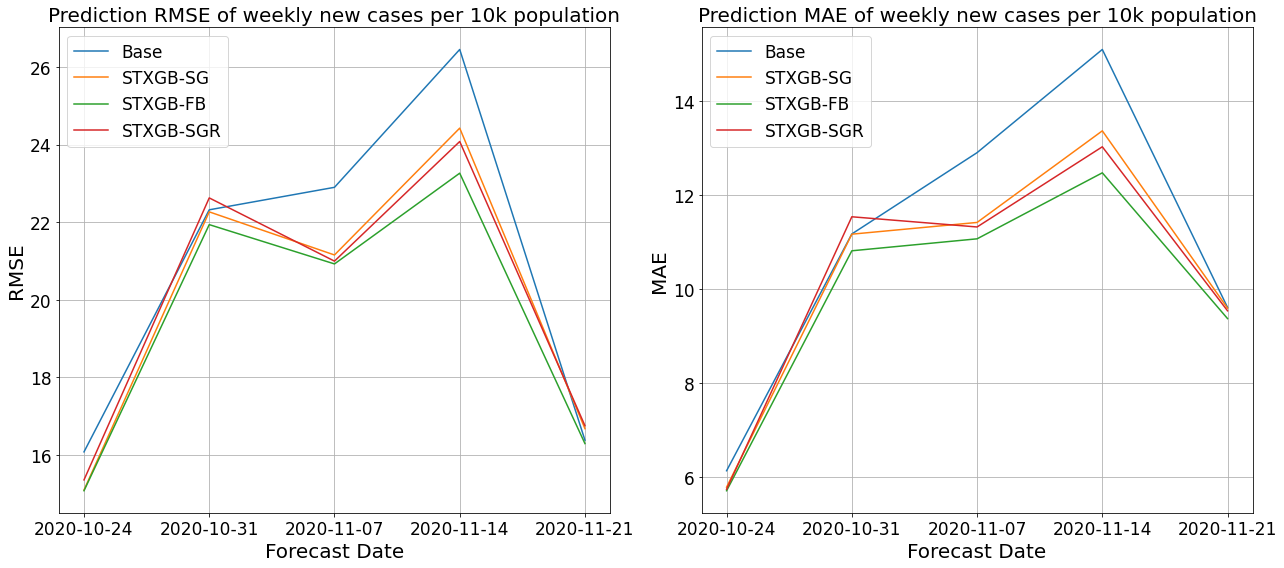

In [20]:
# Plotting 1 week ahead predictions using STXGB and based models
# this is for comparing the performance of the 4 feature sets

error_df_for_map = error_df_xgb_1wk.copy()
error_df_for_map['time step'] = error_df_for_map['time step'].map({0:'2020-10-24',
                                        1:'2020-10-31',
                                        2:'2020-11-07',
                                        3:'2020-11-14',
                                        4:'2020-11-21'})
error_df_for_map['time step'] = pd.to_datetime(error_df_for_map['time step'], infer_datetime_format=True)
error_df_for_map.loc[(error_df_for_map.model == 'base'),'model']='Base'
error_df_for_map.loc[(error_df_for_map.model == 'facebook'),'model']='STXGB-FB'
error_df_for_map.loc[(error_df_for_map.model == 'safegraph'),'model']='STXGB-SG'
error_df_for_map.loc[(error_df_for_map.model == 'safegraph_full'),'model']='STXGB-SGR'


import matplotlib.dates as md


fig, axes = plt.subplots(1,2, figsize=(18, 8))

# in the line below, change 'inc' to 'case' for plotting case instead of case/10k population 
for col, ax in zip(error_df_for_map[['RMSE inc', 'MAE inc']].columns, axes.flatten()): 
    sns.lineplot(data=error_df_for_map, x='time step', y=col, hue='model', ax=ax)
    ax.set_xlabel('Forecast Date')
    ax.set_ylabel(col.split()[0])
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 5))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    if col=='RMSE case': ax.set_title('Prediction RMSE of weekly new confirmed cases', fontsize=20)
    if col=='MAE case': ax.set_title('Prediction MAE of weekly new confirmed cases', fontsize=20)
    if col=='RMSE inc': ax.set_title('Prediction RMSE of weekly new cases per 10k population', fontsize=20)
    if col=='MAE inc': ax.set_title('Prediction MAE of weekly new cases per 10k population', fontsize=20)
    
    ax.legend(loc='upper left')
    ax.grid(True)
    
plt.tight_layout()


## 11. Comparison with Forecast Hub

For comparing our results with the ensemble model, we compared the 1- to 4-week ahead predictions of the STXGB model with the ensemble model.

**in the forecast_hub dataframe, observations with tye=='point' are used for comparison with our models**

First, import covid data downloaded from John Hopkins' repo.

Then, calculate weekly new cases for the 4 weeks after the time step. 

In [6]:
jh_covid_df = pd.read_csv(input_directory + 'time_series_covid19_confirmed_US.csv')

# preprocessing JH COVID data
jh_covid_df.dropna(axis=0, how='any', inplace=True)

jh_covid_df['FIPS'] = jh_covid_df['FIPS'].astype('int64')

jh_covid_df.drop(columns=['UID', 'iso2', 'iso3', 'code3','Country_Region', 'Lat', 'Long_'], inplace=True)

In [8]:
from datetime import datetime, timedelta

#Important: check to see the column index is adherent to the imported df

first_date = datetime.strptime(jh_covid_df.columns[4], '%m/%d/%y').date()

last_date = datetime.strptime(jh_covid_df.columns[-1], '%m/%d/%y').date()

In [9]:
current_date= last_date

previous_date = last_date - timedelta (days=1)


while current_date > first_date:

    #For unix, replace # with - in the time format

    current_col = current_date.strftime('%#m/%#d/%y') #replace # with - in Mac or Linux

    previous_col = previous_date.strftime('%#m/%#d/%y')

    jh_covid_df[previous_col] = np.where(jh_covid_df[previous_col] > jh_covid_df[current_col], jh_covid_df[current_col], jh_covid_df[previous_col])

    current_date = current_date - timedelta(days=1)

    previous_date = previous_date - timedelta(days=1)

### Model Comparison: Forecast Hub Ensemble And STXGB-FB

In [10]:
import geopandas as gpd

counties_xgb = gpd.read_file(input_directory + 'error_map_XGB_defalt.geojson')
counties_xgb_14 = gpd.read_file(input_directory + 'error_map_XGB_14.geojson')
counties_xgb_21 = gpd.read_file(input_directory + 'error_map_XGB_21.geojson')
counties_xgb_28 = gpd.read_file(input_directory + 'error_map_XGB_28.geojson')

In [14]:
from datetime import datetime, timedelta

start_date = datetime(2020, 10, 25)
xgb_error_shapefiles = [counties_xgb, counties_xgb_14, counties_xgb_21, counties_xgb_28]


# creating two dataframe to store RMSE and MAE values
compare_dfs=[]

models_compare = ['Ensemble', 'STXGB-FB']
iterables = [range(5), models_compare]

index_compare = pd.MultiIndex.from_product(iterables, names=["time step", "model"])

comparison_rmse = pd.DataFrame(index=index_compare, columns=['1 wk ahead', '2 wk ahead', '3 wk ahead', '4 wk ahead'], 
                               dtype=float)

comparison_mae = pd.DataFrame(index=index_compare, columns=['1 wk ahead', '2 wk ahead', '3 wk ahead', '4 wk ahead'], 
                               dtype=float)

for i in range(time_steps):
    hub_forecast_date = start_date + timedelta(days=7*i+1)
    hub_file_name = hub_forecast_date.strftime('%Y %m %d') + ' COVIDhub ensemble.csv'
    hub_df = pd.read_csv(input_directory + hub_file_name)
    
    # creating target dates
    start_period = start_date + timedelta(days=7*i)
    end_period = start_period + timedelta(days=6)
    target_date = [start_period.strftime('%#m/%#d/%Y')[:-2], end_period.strftime('%#m/%#d/%Y')[:-2]]
    for j in range(1,4):
        forecast_date = end_period + timedelta(days=7*j)
        target_date.append(forecast_date.strftime('%#m/%#d/%Y')[:-2])
    
    
    # Getting observed case numbers from JH COVID data
    cols = ['FIPS'] + target_date
    compare_df = jh_covid_df[cols]
    
    labels= ['observed_1wk', 'observed_2wk', 'observed_3wk', 'observed_4wk']
    
    for j in range(4):
        compare_df[labels[j]] = compare_df[target_date[j+1]] - compare_df[target_date[0]]
    
    
    labels_pred_xgb= ['xgb_pred_1wk', 'xgb_pred_2wk', 'xgb_pred_3wk', 'xgb_pred_4wk']
    
    k=0

    for xgb_shp in xgb_error_shapefiles:

        df = xgb_shp.copy()
        df['FIPS'] = df['GEOID'].astype('int64')
        pred_col_name = 'delta_case_pred_facebook_' + str(i) # change facebook to safegraph to generate STXG-SG error values
        compare_df = compare_df.merge(df[['FIPS', pred_col_name]], 
                                      how='right', on='FIPS')
        compare_df.rename(columns={pred_col_name:labels_pred_xgb[k]}, inplace=True)

        k+=1
        
    
    counties_xgb['FIPS'] = counties_xgb['GEOID'].astype('int64')
    compare_df = compare_df.merge(counties_xgb[['FIPS', 'GEOID']], on='FIPS')
    
    
    # joining the predictions from forecast hub
    # for each week, values with type point are joined to the dataframe

    target_week_hub = ['1 wk ahead inc case', '2 wk ahead inc case', '3 wk ahead inc case', '4 wk ahead inc case']

    labels_pred_hub= ['hub_pred_1wk', 'hub_pred_2wk', 'hub_pred_3wk', 'hub_pred_4wk']
    
    k=0

    for week in target_week_hub:
        compare_df = compare_df.merge(hub_df[(hub_df['target']== week) & (hub_df['type']=='point')][['location','value']], 
                       how='left', left_on='GEOID', right_on='location')
        compare_df.rename(columns={'value':labels_pred_hub[k]}, inplace=True)
        compare_df.drop('location', axis=1, inplace=True)
        k+=1
        

    compare_dfs.append(compare_df)
    
    target_week = ['_1wk','_2wk','_3wk','_4wk']

    
    rmse_hub_row = []
    mae_hub_row = []
    rmse_xgb_row = []
    mae_xgb_row = []

    for week in target_week:

        rmse_hub_row.append(np.sqrt(mean_squared_error(compare_df['observed'+week],compare_df['hub_pred'+week])))
        rmse_xgb_row.append(np.sqrt(mean_squared_error(compare_df['observed'+week],compare_df['xgb_pred'+week])))

        mae_hub_row.append(mean_absolute_error(compare_df['observed'+week],compare_df['hub_pred'+week]))
        mae_xgb_row.append(mean_absolute_error(compare_df['observed'+week],compare_df['xgb_pred'+week]))

        
    comparison_rmse.loc[i,'Ensemble'] = rmse_hub_row
    comparison_rmse.loc[i,'STXGB-FB'] = rmse_xgb_row
    
    comparison_mae.loc[i,'Ensemble'] = mae_hub_row
    comparison_mae.loc[i,'STXGB-FB'] = mae_xgb_row
    

C:\Users\BehzadVahediTorghabe\anaconda3\envs\tf-2\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\BehzadVahediTorghabe\anaconda3\envs\tf-2\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\BehzadVahediTorghabe\anaconda3\envs\tf-2\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [15]:

target_week = ['_1wk','_2wk','_3wk','_4wk']
combine_errors=[]



for xgb_shp, week in zip((counties_xgb, counties_xgb_14, counties_xgb_21, counties_xgb_28), target_week):
    i=0
    for df in compare_dfs:

    #df_xgb = xgb_shp_2.copy()
        cols = [col for col in df.columns if week in col]
        cols_to_merge = cols + ['GEOID']
        
        xgb_shp = xgb_shp.merge(df[cols_to_merge], how='left', on='GEOID')
        rename_dict = dict()
        for col in cols:
            rename_dict[col] = col + '_' + str(i)

        xgb_shp['error_delta_case_hub_'+str(i)] =  xgb_shp['hub_pred'+week] - xgb_shp['observed'+week]
        xgb_shp['error_delta_case_stxgb_fb_'+str(i)] =  xgb_shp['xgb_pred'+week] - xgb_shp['observed'+week]
        
        xgb_shp['error_delta_inc_hub_'+str(i)] = xgb_shp['error_delta_case_hub_'+str(i)]/ xgb_shp['POPULATION'] * 10000
        xgb_shp['error_delta_inc_stxgb_fb_'+str(i)] = xgb_shp['error_delta_case_stxgb_fb_'+str(i)]/ xgb_shp['POPULATION'] * 10000
        
        xgb_shp.rename(columns=rename_dict, inplace=True)
        i+=1
        
    combine_errors.append(xgb_shp)
        
        

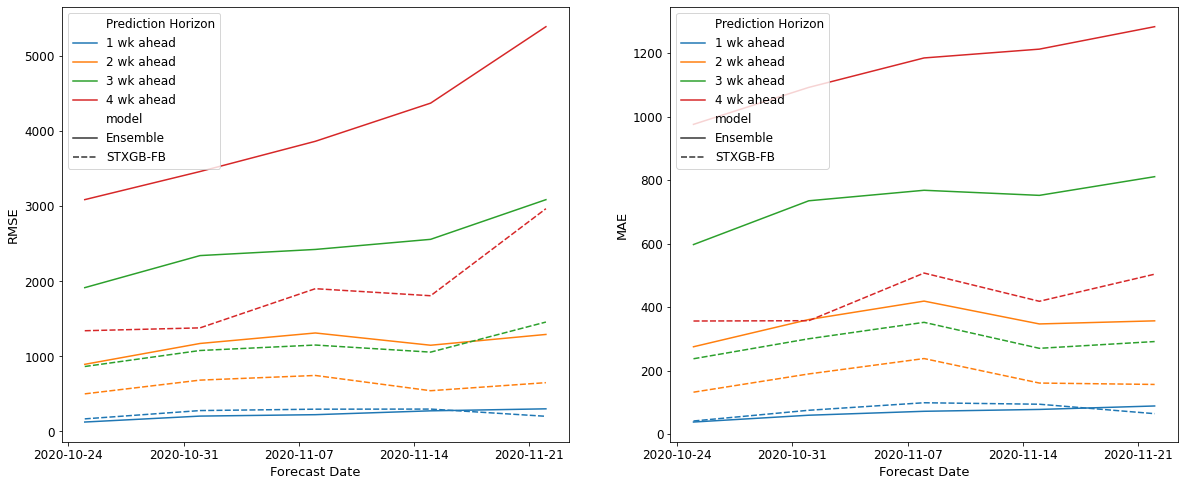

In [25]:
# Plotting 1,2,3, and 4-week ahead predictions of XGBoost-FB and Ensemble model

import matplotlib.dates as md

dfs_for_plot=[comparison_rmse, comparison_mae]
y_labels=['RMSE', 'MAE']

i=0

fig, axes = plt.subplots(1,2,figsize=(20, 8))

for df_plt, ax in zip(dfs_for_plot, axes):

    df = df_plt.reset_index()
    df['time step'] = df['time step'].map({0:'2020-10-25',
                                        1:'2020-11-01',
                                        2:'2020-11-08',
                                        3:'2020-11-15',
                                        4:'2020-11-22'})
    df['time step'] = pd.to_datetime(df['time step'], infer_datetime_format=True)

    df_melt = pd.melt(df, id_vars=['time step', 'model'], value_vars=['1 wk ahead', '2 wk ahead', '3 wk ahead', '4 wk ahead'])
    df_melt.rename(columns={'variable':'Prediction Horizon'}, inplace=True)

    
    sns.lineplot(x="time step", y="value", hue='Prediction Horizon', style='model', data=df_melt, ax=ax)
    legend_labels, _= ax.get_legend_handles_labels()

    ax.set_xlabel('Forecast Date', fontsize=13)
    ax.set_ylabel(y_labels[i], fontsize=13)
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 5))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    ax.legend(loc='upper left')
    #ax.grid()

    i+=1
